# Trabajo Práctico 3

Emmanuel Rojas

In [ ]:
#imports
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles, make_moons, make_blobs
from transformers import BertTokenizer, BertModel

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Neural net from scratch using only torch tensors for gpu acceleration

In [ ]:
"""
This class implements a simple multi-layer feedforward neural network from scratch using PyTorch.

It is designed to be a flexible, manually-coded neural network where the user can specify the
architecture (number of neurons per layer). The network uses the sigmoid activation function
for both the hidden and output layers.
"""
class Neural_Network:
    """
    Initializes the neural network with the number of neurons per layer, the learning rate and the maximum weight.
    """
    def __init__(self, neurons_per_layer, alpha, max_weights):
        self.neurons_per_layer = neurons_per_layer
        self.alpha = alpha
        self.max_weights = max_weights

        #Initializes the weight matrix (W_0) between the input and hidden layer
        #An extra row/column is added to handle the bias
        self.W_0 = torch.rand((self.neurons_per_layer[1] + 1, self.neurons_per_layer[0] + 1), device=device)

        #The first row of weight matrix is set to NaN
        self.W_0[0] = torch.full_like(self.W_0[0], torch.nan)

        #Initializes the weight matrix (W_1)  between the hidden and output layer
        self.W_1 = torch.rand((self.neurons_per_layer[2], self.neurons_per_layer[1] + 1), device=device)

    """
    Performs the forward pass of the network.
    It takes an input tensor X and returns the output of the network.
    """
    def forward(self, X):
        if(len(X) != self.neurons_per_layer[0]):
            raise Exception("The input layer doesn't match original size")

        #Adds a bias term (row of ones) to the input matrix X
        bias = torch.ones((1, len(X[0])), device=device)
        X = torch.vstack((bias, X))

        #Computes the weighted sum for the hidden layer Y
        self.Y = self.W_0 @ X

        #Applies the sigmoid activation function to the hidden layer
        self.Y_a = torch.sigmoid(self.Y)

        #Sets the first row of the activated hidden layer to 1, representing the bias for the next layer.
        self.Y_a[0] = torch.ones_like(self.Y_a[0])

        #Computes the weighted sum for the output layer Z
        self.Z = self.W_1 @ self.Y_a

        #Applies the sigmoid activation function to get the final output (Z_a)
        self.Z_a = torch.sigmoid(self.Z)

        #Returns the predicted class and the output probabilities
        return torch.argmax(self.Z_a), self.Z_a




    """
    Calculates the Mean Squared Error (MSE) loss.
    This measures how different the network's prediction (self.Z_a) is from the true target (t).
    """
    def calc_loss(self, t):
        return torch.mean((self.Z_a - t) ** 2)

    """
    Calculates the accuracy of the model's predictions.
    It compares the predicted class indices with the true class indices.
    """
    def calc_accuracy(self, x, t):
        #Compares the index of the max value for predictions and targets
        res = torch.sum(x.argmax(dim=0) == t.argmax(dim=0), dim=0)
        return res / len(x[0]) #returns the mean accuracy

    def f1(self, x, t):
        tp = torch.sum(x.argmax(dim=0) == t.argmax(dim=0), dim=0)
        tn = torch.sum(x.argmin(dim=0) == t.argmin(dim=0), dim=0)
        fp = torch.sum(x.argmax(dim=0) != t.argmax(dim=0), dim=0)
        fn = torch.sum(x.argmin(dim=0) != t.argmin(dim=0), dim=0)
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        return (2 * precision * recall) / (precision + recall)

    def calc_f1(self, x, t):
        self.forward(x)
        return self.f1(self.Z_a, t)


    """
    Calculates the derivative of the MSE loss function with respect to the output activations.
    This is the first step in backpropagation.
    """
    def loss_deriv(self, t):
        return 2/self.Z_a.numel() * (self.Z_a - t)

    """
    Calculates the derivative of the sigmoid activation function.
    """
    def sigmoid_dx(self, activated):
        return activated * (1 - activated)

    """
    Performs the backpropagation algorithm.
    It calculates the gradients of the loss with respect to each weight matrix (W_0 and W_1).
    These gradients indicate how much each weight should change to reduce the loss.
    """
    def backwards(self, X, t):
        bias = torch.ones((1, len(X[0])), device=device)
        X = torch.vstack((bias, X))

        #  Gradient of Loss w.r.t. Output (dL/dO)
        dL_dO = self.loss_deriv(t)

        # Gradient of Output w.r.t. pre-activation Output (dO/dZ)
        dO_dZ = self.sigmoid_dx(self.Z_a)

        # Gradient of Loss w.r.t. pre-activation Output (dL/dZ)
        dL_dZ = dL_dO * dO_dZ

        # Gradient of Loss w.r.t. weights W1 (dL/dW1)
        # This is the gradient for the hidden-to-output layer weights.
        dL_dW1 = dL_dZ @ self.Y_a.T #First grad

        # Propagate the error back to the hidden layer's activations (dL/dYa)
        dL_dYa = self.W_1.T @ dL_dZ

        # Gradient of Loss w.r.t. pre-activation Hidden layer (dL/dY)
        dL_dY = self.sigmoid_dx(self.Y_a) * dL_dYa

        # This is the gradient for the input-to-hidden layer weights.
        dL_dW0 = dL_dY @ X.T #Second grad

        return (dL_dW0, dL_dW1)


    # Updates the network´s weights using gradient descent
    def optimize(self, alpha):
        # Update weights by moving in the opposite direction of the gradient.
        self.W_0 = self.W_0 - alpha * self.del_W0
        self.W_1 = self.W_1 - alpha * self.del_W1


    """
    The main training loop of the neural network.
    It iterates for a specified number of epochs, performing forward pass, backpropagation,
    and weight updates. It also evaluates the model on validation data.
    """
    def train_nn(self, X_train, T_train, X_valid, T_valid, epochs = 50, alpha = 0.1, gamma = 0.1, plot = False):

        epoch_count = []
        loss_count = []
        accuracy_count = []

        for epoch in range(epochs):

            #Perform forward pass
            self.forward(X_train)

            #Perform backprop
            self.del_W0, self.del_W1 = self.backwards(X_train, T_train)

            self.optimize(alpha)

            #Check loss against validation

            self.forward(X_valid)
            valid_loss = self.calc_loss(T_valid)
            valid_acc = self.calc_accuracy(self.Z_a, T_valid)

            # Store metrics for plotting.
            epoch_count.append(epoch)
            loss_count.append(valid_loss)
            accuracy_count.append(valid_acc)

        # If plot is True, visualize the training progress.
        if(plot):
            epoch_count = torch.tensor(epoch_count, device="cpu")
            loss_count = torch.tensor(loss_count, device="cpu")
            accuracy_count = torch.tensor(accuracy_count, device="cpu")
            plt.plot(epoch_count, loss_count)
            plt.xlabel("Épocas")
            plt.ylabel("Pérdida")
            plt.show()
            plt.plot(epoch_count, accuracy_count)
            plt.xlabel("Épocas")
            plt.ylabel("Precisión")
            plt.show()

In [ ]:
X_train = torch.tensor([
    [1, 1, 0, 0],
    [1, 0, 1, 0]
], dtype=torch.float, device=device)
T_train = torch.tensor([
    [1, 0, 0, 1],
    [0, 1, 1, 0]
], device=device)

nn = Neural_Network((2, 2, 2), 0.1, 1)

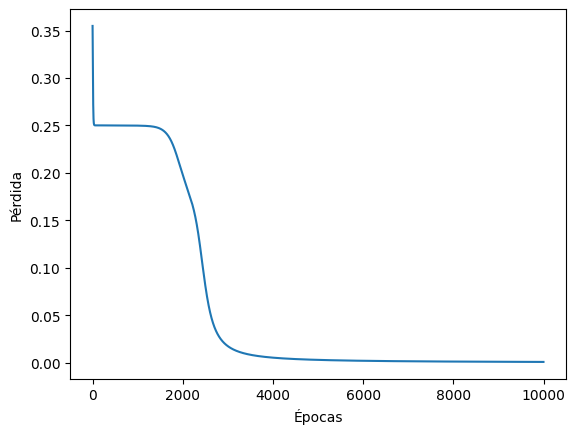

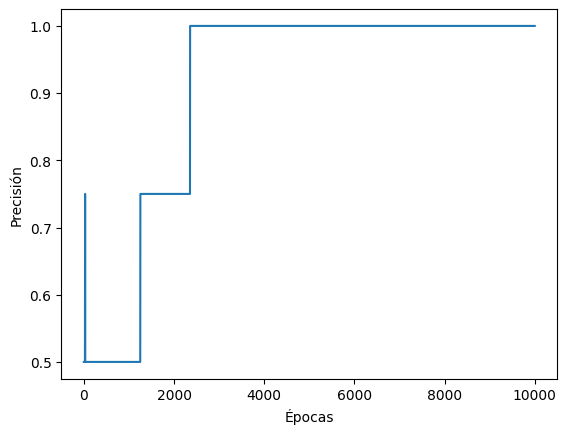

In [ ]:
nn.train_nn(X_train=X_train, T_train=T_train, X_valid=X_train, T_valid=T_train, epochs=10000, alpha = 0.8, plot=True)

In [ ]:
X_test = torch.tensor([
    [0],
    [1]
], device = device)

res, out = nn.forward(X_test)
print(res, out)

tensor(1, device='cuda:0') tensor([[0.0287],
        [0.9712]], device='cuda:0')


# Clasificación en $\mathbb{R}^2$

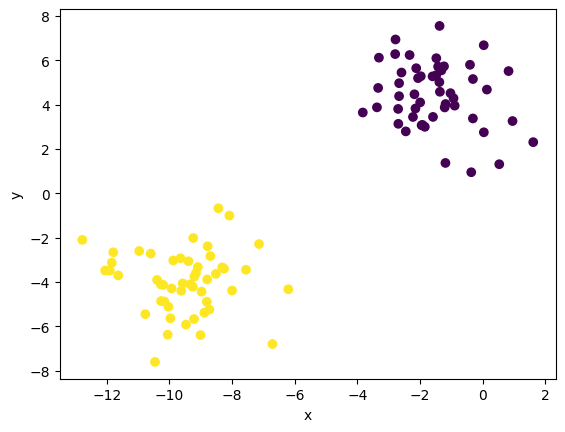

In [ ]:
def gen_data(data_dist, plot=False):

    """
    Generates and preprocesses a dataset for binary classification.
    This function can create either blob-like or moon-shaped data clusters using
    scikit-learn's dataset generators. It then converts the data into PyTorch tensors,
    applies one-hot encoding to the labels, transposes the matrices to fit the
    neural network's expected input format (features x samples), and finally splits
    the data into training and validation sets.
    """

    # Default to generating blob-like data using scikit-learn's make_blobs
    X, y = make_blobs(centers=2, cluster_std=1.5, random_state=1) #ignore error

    # If "moons" is specified, overwrite the blob data with moon-shaped data
    if(data_dist == "moons"):
        X, y = make_moons(n_samples=100, noise=0.1, random_state=42)

    # If "moons" is specified, overwrite the blob data with moon-shaped data
    if(plot):
        plt.scatter(X[:, 0], X[:, 1], c=y)
        plt.xlabel("x")
        plt.ylabel("y")
        plt.show()

    # Convert the NumPy arrays (X, y) to PyTorch tensors and move them to the selected device
    X = torch.tensor(X, device=device, dtype=torch.float)
    y = torch.tensor(y, device=device)

    # Create a zero tensor of shape (number of samples, number of classes)
    one_hot = torch.zeros((len(y), 2), device=device)

    # Create a zero tensor of shape (number of samples, number of classes)
    one_hot[torch.arange(y.size(0)), y] = 1

    # Transpose the one-hot tensor to have the shape (number of classes, number of samples)
    y = one_hot.T

    # Transpose the input data X to match the expected network format (features, samples)
    X = X.T

    # Calculate the split point for an 80/20 train-validation split
    split = int(len(X[0]) *  0.8)

    # Split the data into training (first 80%) and validation (last 20%) sets
    X_train = X[:, :split]
    X_val = X[:, split:]

    y_train = y[:, :split]
    y_val = y[:, split:]

    return X_train, y_train, X_val, y_val

X_train, y_train, X_val, y_val = gen_data("blobs", plot=True)





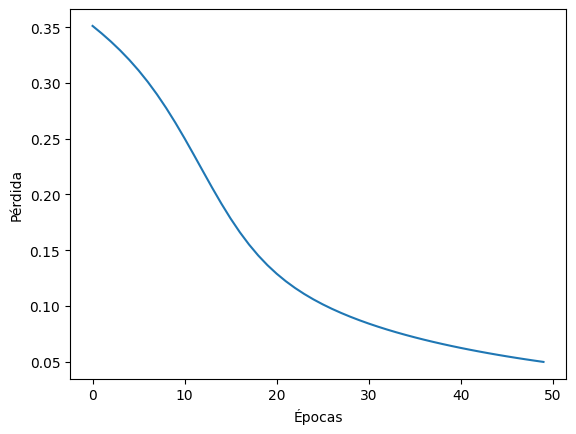

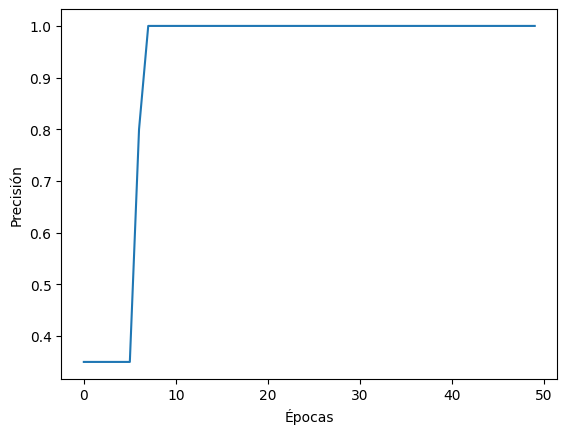

In [ ]:
r2net = Neural_Network((2, 4, 2), 0.1, 1)
r2net.train_nn(X_train=X_train, T_train=y_train, X_valid=X_val, T_valid=y_val, alpha=0.7, plot=True, epochs=50)

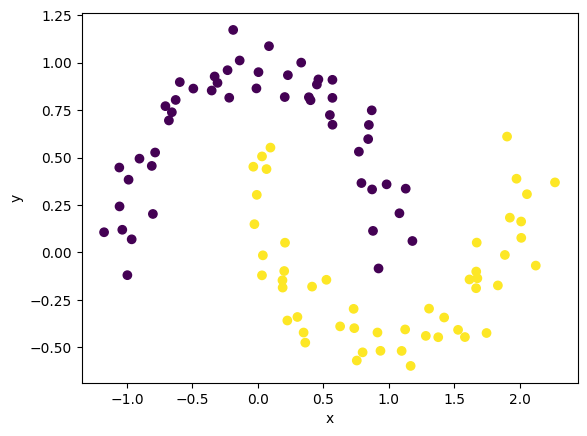

In [ ]:
X_train, y_train, X_val, y_val = gen_data("moons", plot=True)

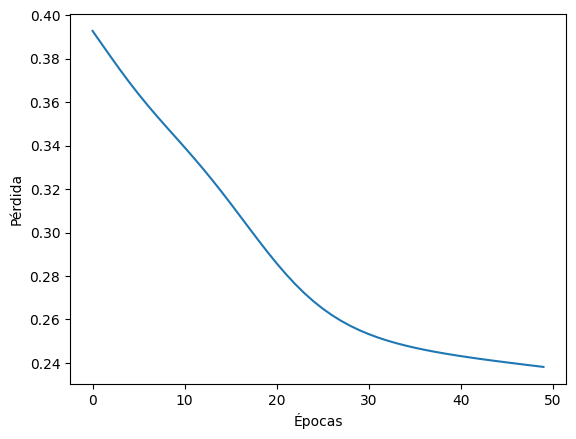

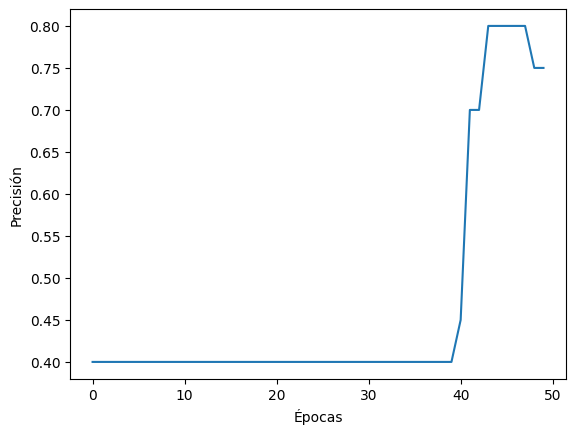

In [ ]:
r3net = Neural_Network((2, 4, 2), 0.1, 1)
r3net.train_nn(X_train=X_train, T_train=y_train, X_valid=X_val, T_valid=y_val, alpha=0.7, plot=True, epochs=50)

In [ ]:
data = []
with open("SMSSpamCollection", "r", encoding="utf-8") as f:
    for line in f:
        parts = line.strip().split('\t')
        if len(parts) == 2:
            d1, d2 = parts
            data.append([d1, d2])



In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
def get_bert_embedding(text):
    """
    Generates a sentence-level embedding for a given text using a pre-trained BERT model.

    This function takes a string as input, tokenizes it to be BERT-compatible,
    and then passes it through the model to get a fixed-size numerical representation.
    It specifically uses the model's "pooler output" as the final embedding.
    """
    # Convert the raw text into numerical tokens that the BERT model can process.
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)

    # This is crucial for inference as it reduces memory consumption and speeds up computation,
    # since we don't need to track operations for backpropagation.
    with torch.no_grad():
        outputs = model(**inputs)
    # Pass the tokenized inputs to the pre-trained model.
    return outputs.pooler_output.squeeze().numpy()

In [ ]:
labels = []
inputs = torch.tensor([])
for i in data:
    current = torch.tensor(get_bert_embedding(i[1]))
    current = current.unsqueeze(1)
    if(len(inputs) == 0):
        inputs = current
    else:
        inputs = torch.hstack((inputs, current))
    if(i[0] == "ham"):
        labels.append(1)
    else: labels.append(0)

In [ ]:
inputs.shape

torch.Size([768, 5574])

In [ ]:
labels = torch.tensor(labels)

/tmp/ipython-input-1292910071.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


In [ ]:
def split_data(X, t):
    """
    Preprocesses and splits feature and target data into training, validation, and test sets.

    This function first normalizes the input feature matrix `X` and then splits both
    `X` and the target labels `t` into a 70% training set, a 15% validation set,
    and a 15% test set. The target labels `t` are converted into a one-hot
    encoded format before being split.
    """
    # Normalize the feature tensor X.
    # Scale the result by 100. This step amplifies the magnitude of the feature vectors after they have been scaled down by normalization.
    X = torch.nn.functional.normalize(X, dim=1) * 100

    # Determine the number of samples for the training set (70% of the data).
    trainer = int(len(X[0]) * 0.7)

    # Determine the number of samples for the validation set (15% of the data).
    valider = int(len(X[0]) * 0.15)

    # The training set contains the first 70% of the samples.
    X_train = X[:, : trainer]
    # The validation set contains the next 15% of the samples.
    X_val = X[:, trainer : trainer + valider]
    # The test set contains the remaining 15% of the samples.
    X_test = X[:, trainer + valider :]

    # Create a zero tensor with shape [number_of_classes, number_of_samples].
    one_hot = torch.zeros((2, len(X[0])))

    # Perform one-hot encoding in a single, efficient operation.
    one_hot[t, torch.arange(len(X[0]))] = 1

    # Split the one-hot encoded labels to correspond with the feature splits.
    y_train = one_hot[:, : trainer]
    y_val = one_hot[:, trainer : trainer + valider]
    y_test = one_hot[:, trainer + valider :]
    return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(inputs, labels)

X_train = X_train.to(device)
X_val = X_val.to(device)
X_test = X_test.to(device)

y_train = y_train.to(device)
y_val = y_val.to(device)
y_test = y_test.to(device)

In [ ]:
r4net = Neural_Network((768, 120, 2), 0.1, 1)
r5net = Neural_Network((768, 50, 2), 0.1, 1)

In [ ]:
def compare(inputs, labels):
    a_net = Neural_Network((768, 120, 2), 0.1, 1)
    b_net = Neural_Network((768, 50, 2), 0.1, 1)
    for i in range(10):
        a_net = Neural_Network((768, 120, 2), 0.1, 1)
        b_net = Neural_Network((768, 50, 2), 0.1, 1)
        perm = torch.randperm(len(inputs[0]))

        shuffled_data = inputs[:, perm]

        shuffled_labels = labels[perm]

        X_train, X_val, X_test, y_train, y_val, y_test = split_data(shuffled_data, shuffled_labels)

        X_train = X_train.to(device)
        X_val = X_val.to(device)
        X_test = X_test.to(device)

        y_train = y_train.to(device)
        y_val = y_val.to(device)
        y_test = y_test.to(device)
        a_net.train_nn(X_train=X_train,
               T_train=y_train,
               X_valid=X_val,
               T_valid=y_val,
               alpha=1,
               plot=True,
               epochs=200)
        b_net.train_nn(X_train=X_train,
               T_train=y_train,
               X_valid=X_val,
               T_valid=y_val,
               alpha=1,
               plot=True,
               epochs=200)
        print("test number:", i + 1)
        print("nn A f1 score", a_net.calc_f1(X_test, y_test).item())
        print("nn B f1 score", b_net.calc_f1(X_test, y_test).item())

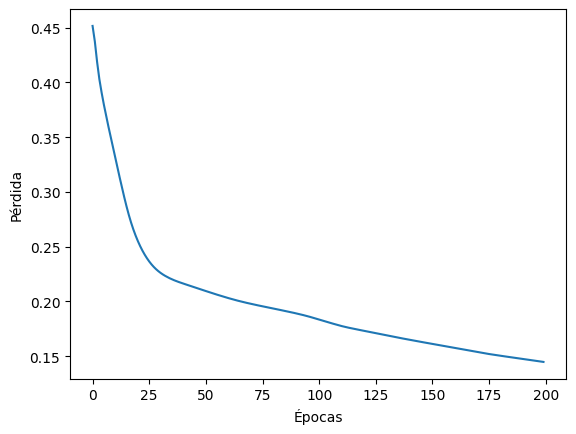

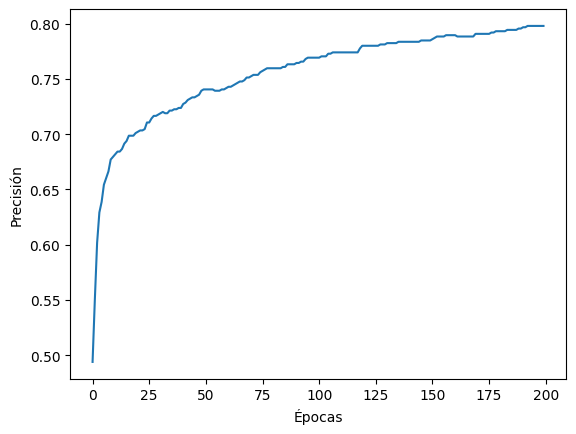

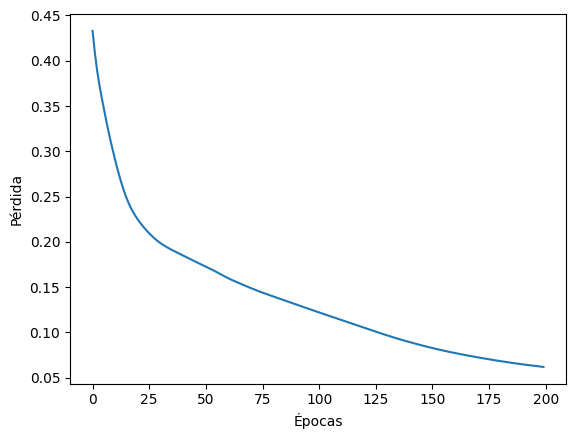

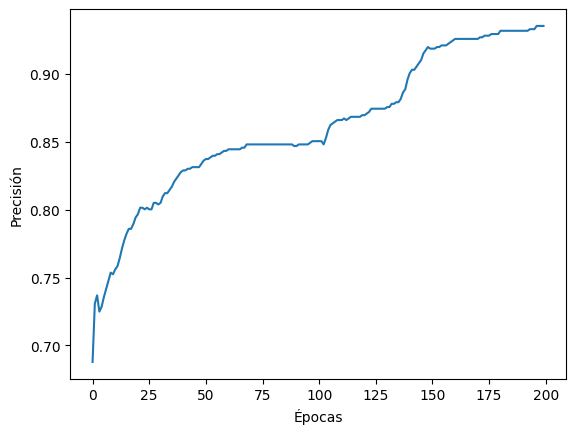

test number: 1
nn A f1 score 0.854357123374939
nn B f1 score 0.9545997381210327


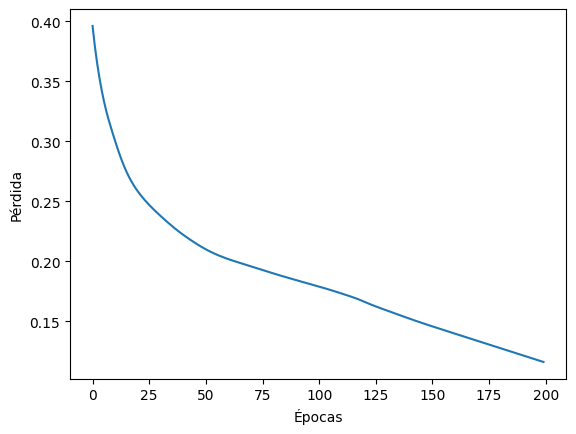

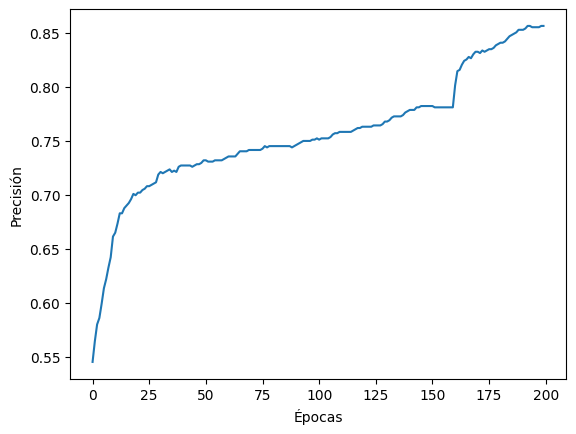

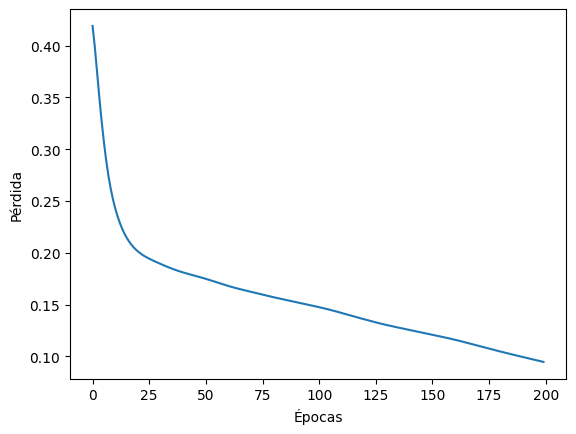

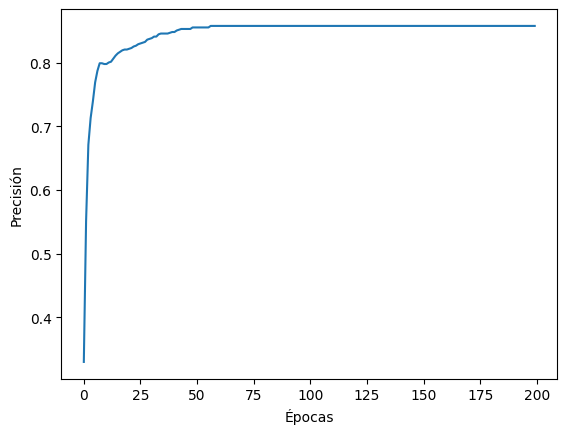

test number: 2
nn A f1 score 0.9047618508338928
nn B f1 score 0.8649940490722656


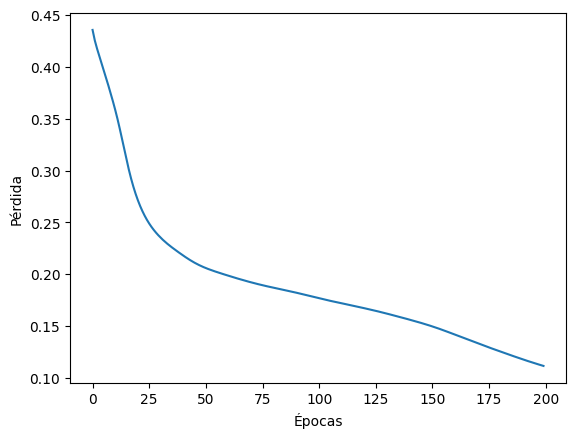

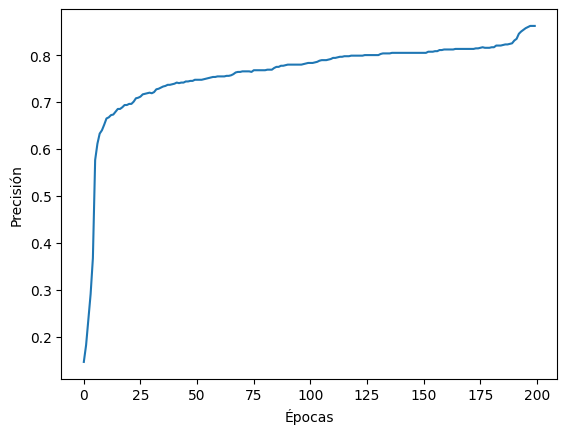

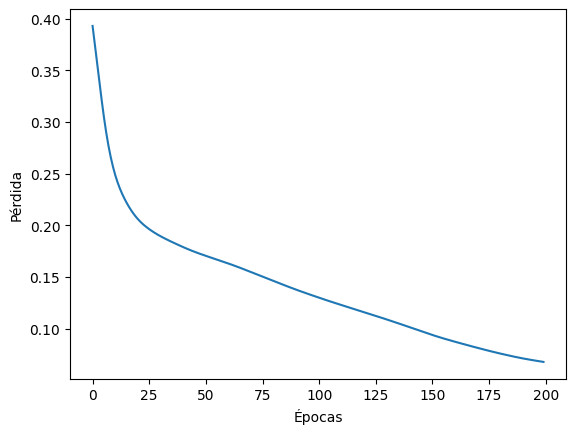

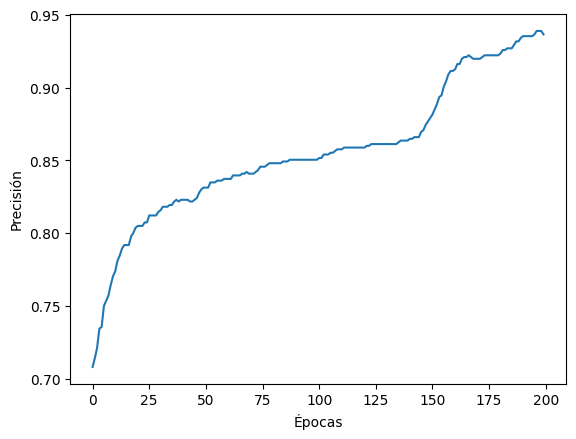

test number: 3
nn A f1 score 0.8713235259056091
nn B f1 score 0.9330943822860718


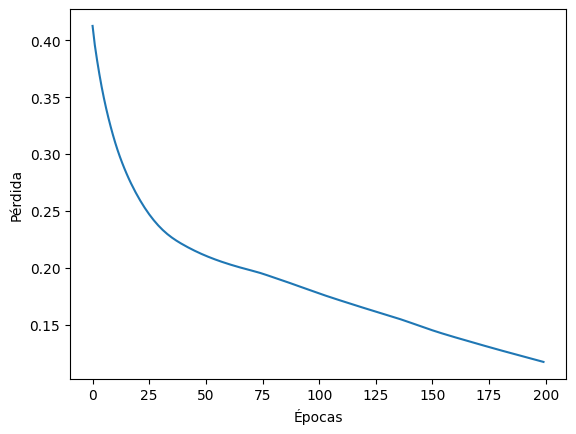

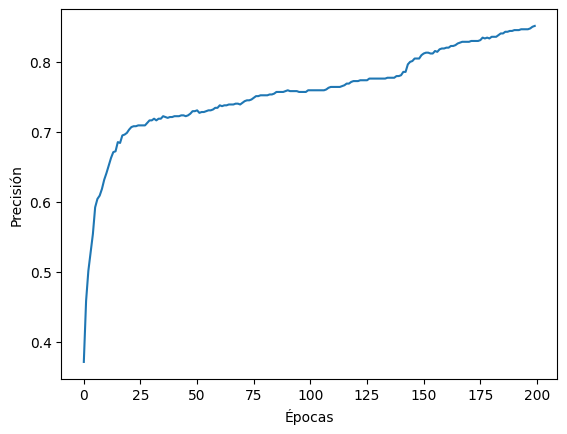

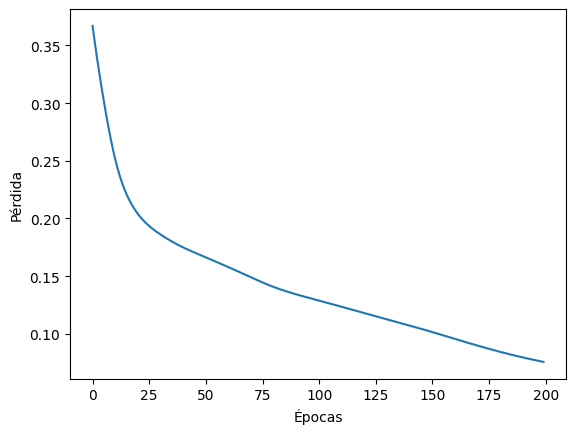

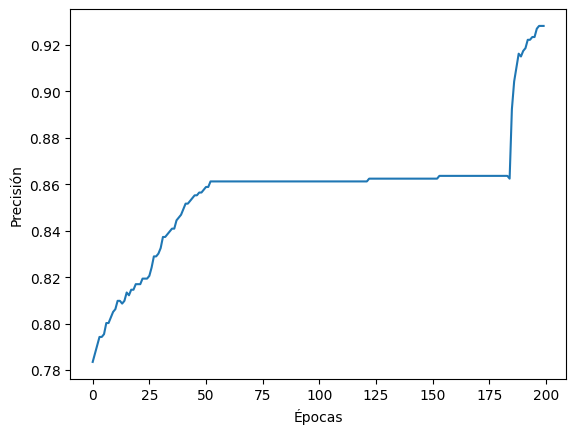

test number: 4
nn A f1 score 0.8957434296607971
nn B f1 score 0.9462365508079529


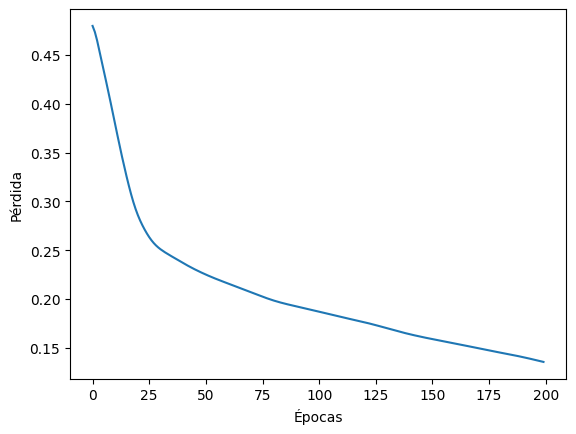

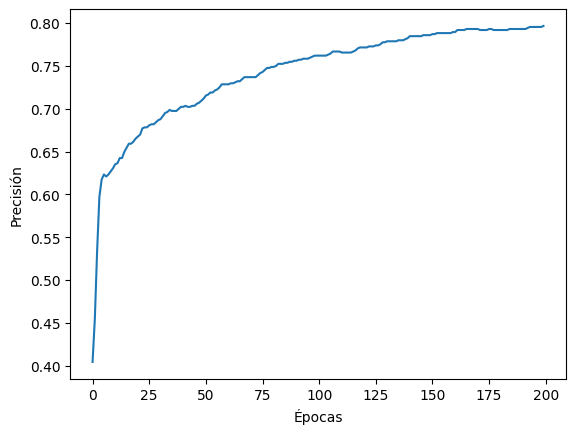

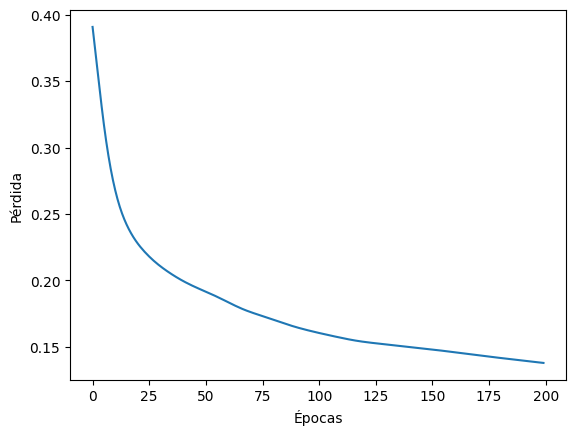

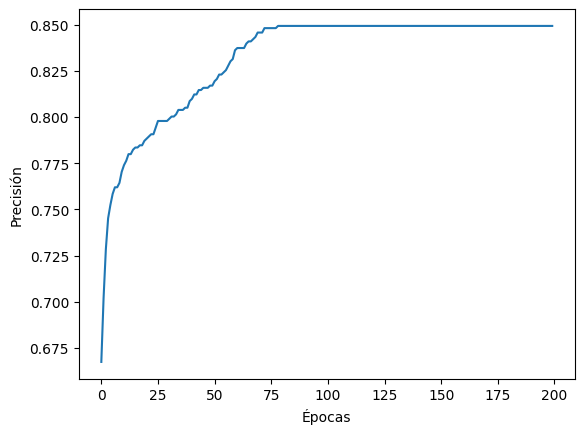

test number: 5
nn A f1 score 0.834963321685791
nn B f1 score 0.8614097833633423


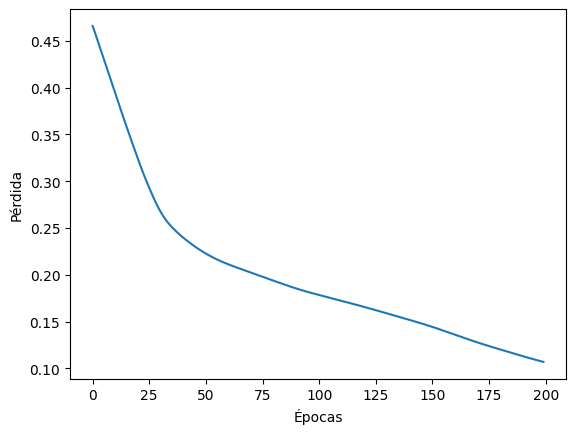

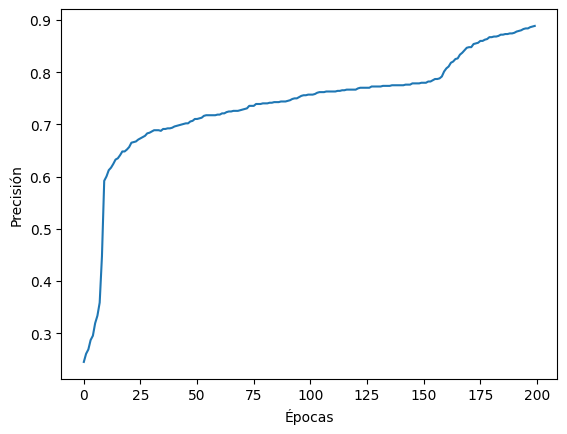

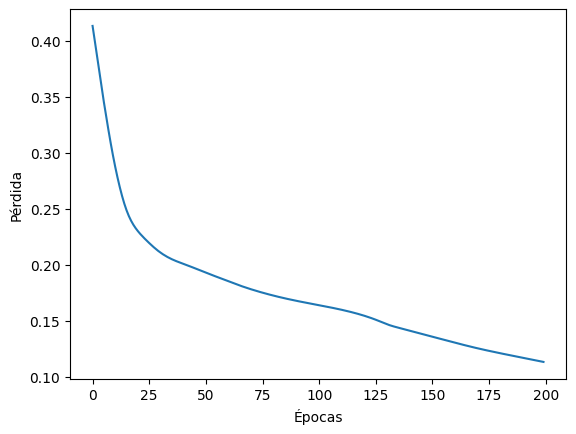

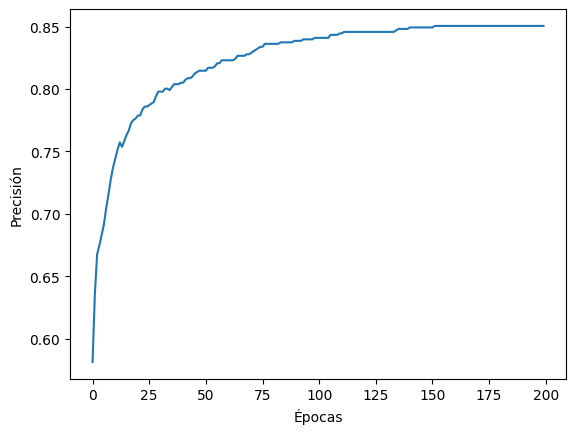

test number: 6
nn A f1 score 0.9162079095840454
nn B f1 score 0.8721624612808228


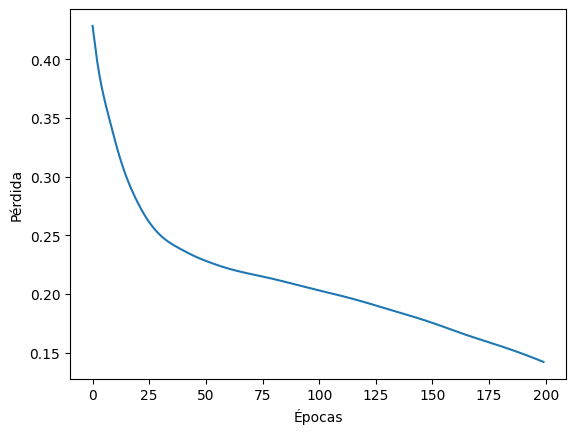

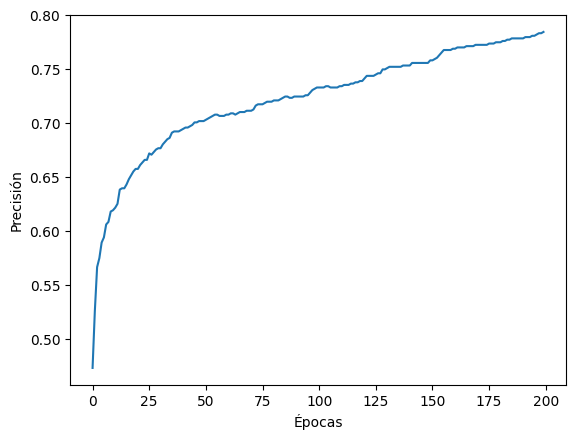

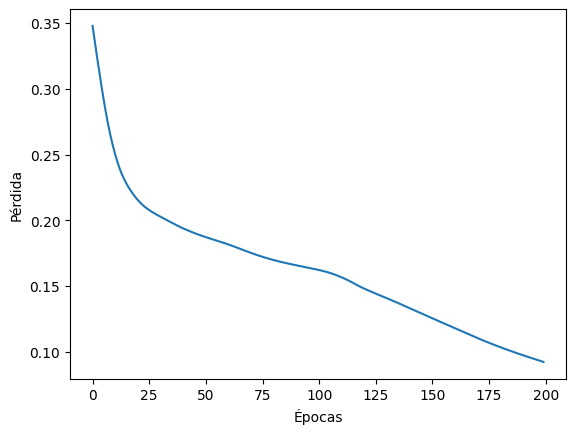

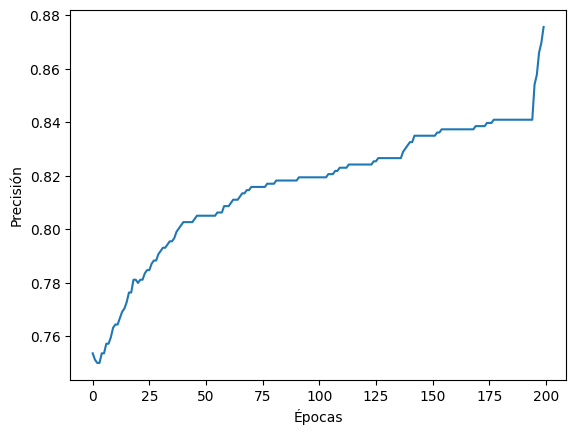

test number: 7
nn A f1 score 0.8348680138587952
nn B f1 score 0.8924731016159058


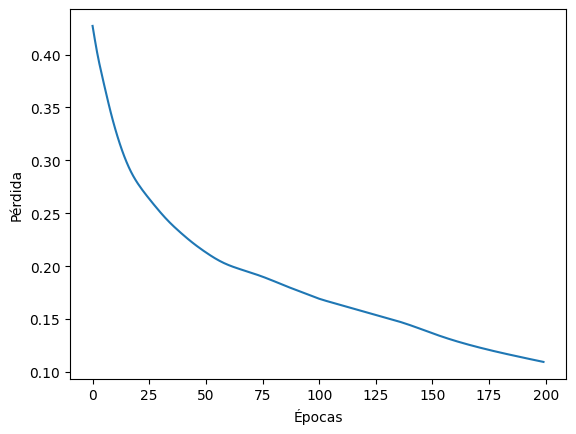

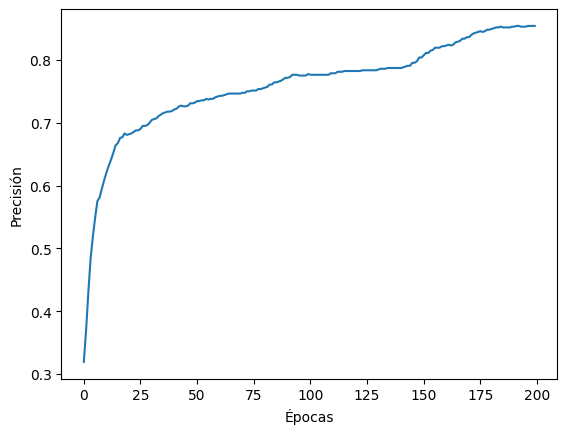

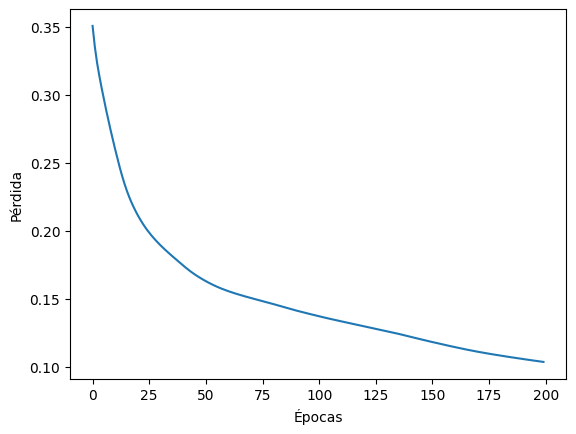

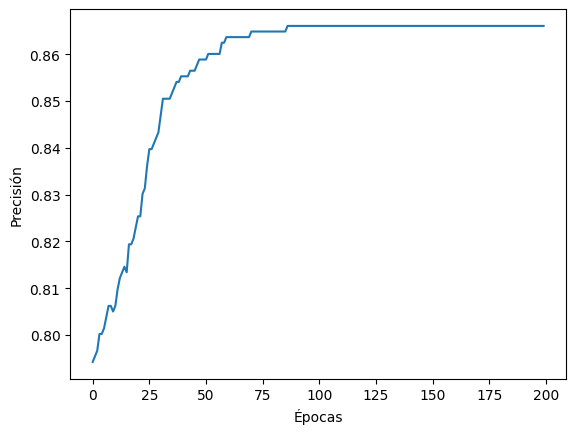

test number: 8
nn A f1 score 0.8948985934257507
nn B f1 score 0.8458780646324158


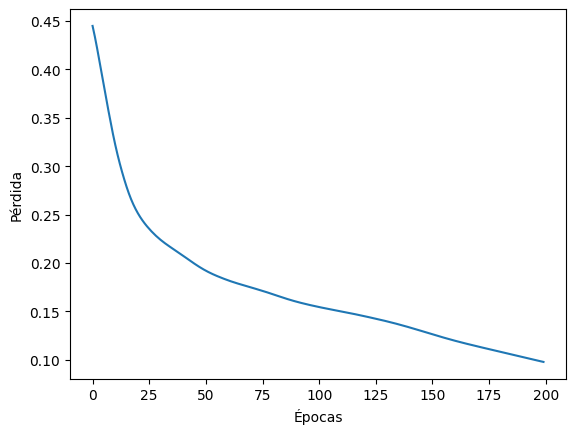

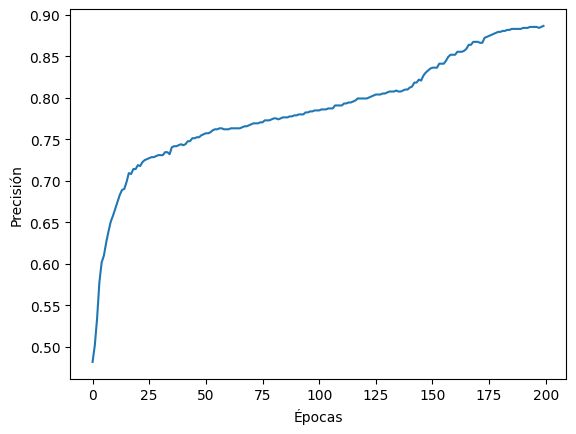

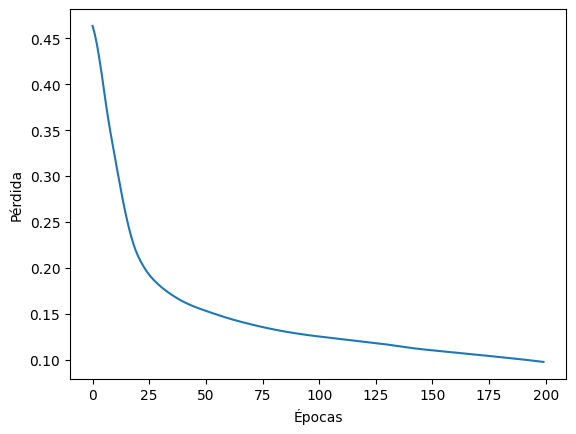

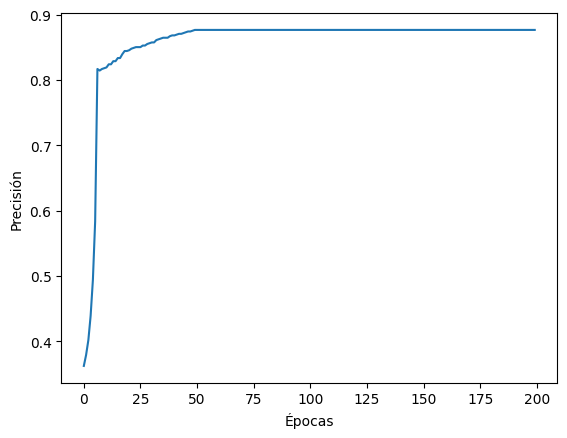

test number: 9
nn A f1 score 0.8944785594940186
nn B f1 score 0.8745519518852234


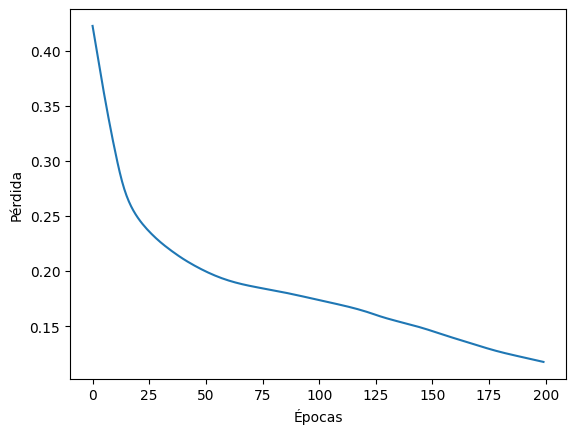

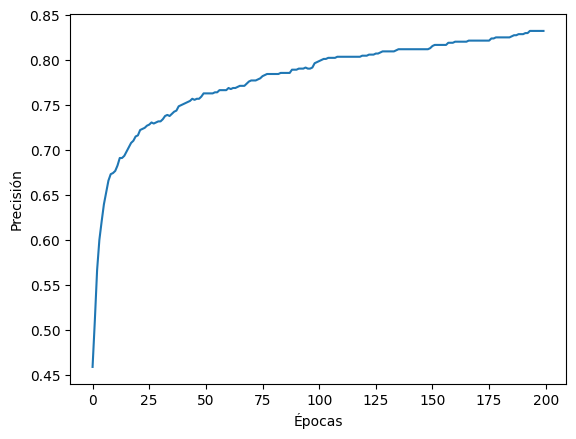

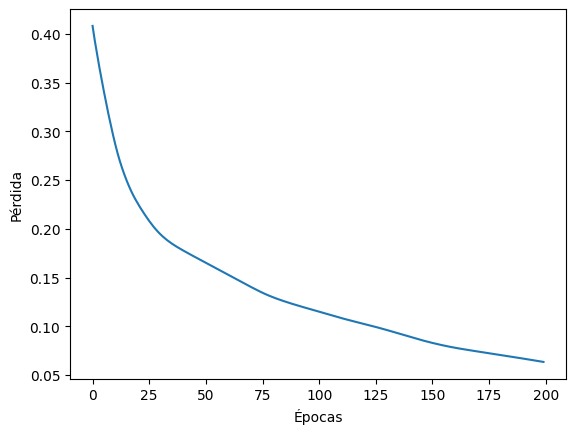

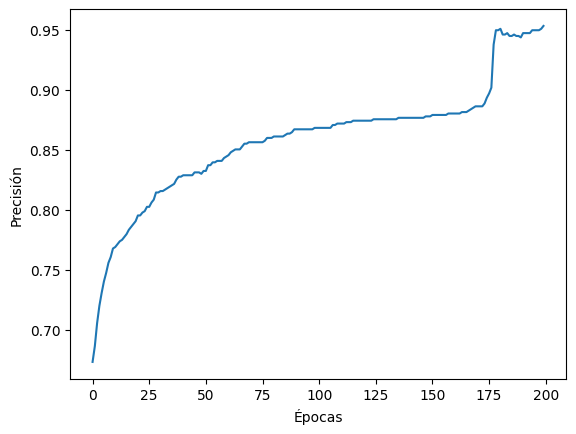

test number: 10
nn A f1 score 0.8068880438804626
nn B f1 score 0.9426523447036743


In [ ]:
compare(inputs, labels)

In [ ]:
r4net.calc_f1(X_test, y_test)

tensor(0.9684, device='cuda:0')